In [1]:
"""
该模块定义了两个用于文本分类的类，分别使用BERT和BERT与LSTM结合。
类:
    BertClassifier: 使用BERT进行文本分类的分类器。
    BertLstmClassifier: 使用BERT和双向LSTM进行文本分类的分类器。
类:
    BertClassifier:
        方法:
            __init__(self, bert_config, num_labels): 使用给定的BERT配置和标签数量初始化BertClassifier。
            forward(self, input_ids, attention_mask=None, token_type_ids=None): 定义BertClassifier的前向传播。
    BertLstmClassifier:
        方法:
            __init__(self, bert_config, num_labels): 使用给定的BERT配置和标签数量初始化BertLstmClassifier。
            forward(self, input_ids, attention_mask=None, token_type_ids=None): 定义BertLstmClassifier的前向传播。
"""


import torch.nn as nn
from transformers import BertModel, BertTokenizer


class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits
    
    
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(bert_config.hidden_size, bert_config.hidden_size, num_layers=2,batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size * 2, num_labels) ## 双向LSTM
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_output[:, -1, :])
        return logits

/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from torch.utils.data import Dataset
import json
import numpy as np
import torch

class _2016Dataset(Dataset):
    def __init__(self, file_path, tokenizer,max_length=512):
        self.labels = ['moved', 'angry', 'funny', 'sad', 'novel', 'shocked']
        self.labels_id = {label: i for i, label in enumerate(self.labels)}
        self.tokenizer = tokenizer
        self.input_ids = []
        self.token_type_ids = []
        self.attention_mask = []
        self.label_id = []
        self.load_data(file_path,max_length)

        
    def load_data(self, file_path,max_length=512):
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            
        for item in data:
            text = item['news']
            # 过滤掉不需要的字段
            emotions = {k: v for k, v in item.items() if k in self.labels}
            # 找到值最大的情感字段
            label = max(emotions, key=emotions.get)
            label_id = self.labels_id[label]
            token = self.tokenizer(text, max_length=max_length, add_special_tokens=True, padding='max_length', truncation=True, return_tensors='pt')
            self.input_ids.append(token['input_ids'].clone().detach().to(dtype=torch.long))
            self.token_type_ids.append(token['token_type_ids'].clone().detach().to(dtype=torch.long))
            self.attention_mask.append(token['attention_mask'].clone().detach().to(dtype=torch.long))
            self.label_id.append(label_id)
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index].squeeze(0), self.token_type_ids[index].squeeze(0), self.attention_mask[index].squeeze(0), self.label_id[index]

tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')
test_data = _2016Dataset('data/2016.json', tokenizer)

print(len(test_data))

# 获取第一条数据
input_ids, token_type_ids, attention_mask, label_id = test_data[0]

# 解码 input_ids
decoded_text = tokenizer.decode(input_ids.squeeze().tolist(), skip_special_tokens=True)

print("解码后的文本:", decoded_text)
print("情感标签ID:", label_id)
print("情感标签名称:", test_data.labels[label_id])


5257
解码后的文本: 媒 体 揭 课 程 辅 导 乱 象 : 让 学 员 续 费 是 老 师 首 要 任 务 暑 假 期 间 ， 不 少 孩 子 参 加 了 各 种 课 程 辅 导 班 。 记 者 调 查 发 现 ， 那 些 宣 称 一 对 一 独 创 教 学 法 的 课 程 辅 导 机 构 ， 不 少 利 用 中 高 考 状 元 高 分 获 得 者 等 进 行 夸 大 宣 传 ， 有 的 一 期 课 程 竟 高 达 5 万 元 ， 而 老 师 的 首 要 任 务 是 让 学 生 不 断 续 费 并 介 绍 新 学 员 。 专 门 招 募 尖 子 生 做 宣 传 培 训 基 本 费 用 每 课 时 200 元 ， 一 个 暑 假 50 个 课 时 ； 一 对 一 辅 导 每 课 时 300 元 ， 一 期 课 程 5 万 多 元 记 者 近 日 走 访 多 地 发 现 ， 暑 期 课 程 辅 导 班 市 场 火 热 。 不 少 机 构 都 打 出 了 培 养 出 中 高 考 状 元 学 员 成 绩 大 幅 提 升 等 宣 传 标 语 。 记 者 对 那 些 写 在 宣 传 单 和 网 站 上 的 成 功 案 例 作 了 分 析 ， 一 些 疑 点 浮 出 水 面 ， 甚 至 还 有 一 些 成 功 案 例 撞 车 的 现 象 。 比 如 在 深 圳 ， 学 而 思 培 优 和 邦 德 两 家 教 育 培 训 机 构 均 宣 称 ， 2015 年 深 圳 市 理 科 中 考 状 元 是 他 们 培 养 的 。 有 些 机 构 专 门 招 募 尖 子 生 进 行 免 费 培 训 ， 主 要 目 的 就 是 在 升 学 考 试 之 后 将 高 分 获 得 者 用 作 宣 传 。 南 京 一 家 教 育 机 构 在 其 2015 年 中 考 喜 报 里 突 出 宣 传 的 南 京 哈 佛 班 学 员 ， 实 际 上 是 今 年 4 月 份 该 机 构 在 南 京 多 所 重 点 中 学 里 集 中 选 拔 出 来 的 尖 子 生 ， 以 免 费 培 训 换 取 中 考 之 后 的 宣 传 权 。 记 者 调 查 发 现 ， 不 少 培 训 机 构 缺 乏 资 质 。 深 圳 市 教 育 局 最 新 发 布 的 《 深 圳 市 教 育 培 训 机
情感标签ID: 1
情感

In [3]:
#分割数据集
import json
import random

# 加载原始数据集
with open('data/2016.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 打乱数据集
random.shuffle(data)

# 按 9:1 分割数据集
split_index = int(len(data) * 0.9)
train_data = data[:split_index]
test_data = data[split_index:]

# 保存训练集到 train.json
with open('data/train.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

# 保存测试集到 test.json
with open('data/test.json', 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 4731
测试集大小: 526


In [4]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, AdamW, BertConfig
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics

def train():
    model_path = "model/bert-base-chinese"
    data_path = "data/"
    batch_size = 8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 10
    learning_rate = 5e-6
    tokenizer = BertTokenizer.from_pretrained(model_path)
    
    train_dataset = _2016Dataset(data_path + 'train.json', tokenizer)
    valid_dataset = _2016Dataset(data_path + 'test.json', tokenizer)

    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    bert_config = BertConfig.from_pretrained(model_path)
    num_labels = len(train_dataset.labels)
    
    model = BertClassifier(bert_config, num_labels).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    criterion = nn.CrossEntropyLoss()
    
    best_f1 = 0
    
    # 用于记录每个 epoch 的分类报告、训练损失和验证损失数据
    report_data = []
    train_losses = []
    valid_losses = []
    
    for epoch in range(1, epochs + 1):
        model.train()
        losses = 0
        accuracy = 0
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_bar = tqdm(train_dataloader, ncols=100)
        
        for input_ids, token_type_ids, attention_mask, label_id in train_bar:
            
            model.zero_grad()
            train_bar.set_description(f"Epoch {epoch}")
            
            output = model(input_ids.to(device), attention_mask=attention_mask.to(device), token_type_ids=token_type_ids.to(device))

            loss = criterion(output, label_id.to(device))
            
            losses += loss.item()
            
            pred_labels = torch.argmax(output, dim=1)
            acc = torch.sum(pred_labels == label_id.to(device)).item() / len(label_id)
            accuracy += acc
            
            loss.backward()
            optimizer.step()
            train_bar.set_postfix(loss=loss.item(), acc=acc)
            
        average_loss = losses / len(train_dataloader)
        average_acc = accuracy / len(train_dataloader)
        
        # 保存训练损失
        train_losses.append(average_loss)
        
        print('\tTrain ACC:', average_acc, '\tLoss:', average_loss)
        
        model.eval()
        losses = 0
        pred_labels = []
        true_labels = []
        valid_bar = tqdm(valid_dataloader, ncols=100)
        
        for input_ids, token_type_ids, attention_mask, label_id in valid_bar:
            valid_bar.set_description(f'Epoch {epoch} valid')

            output = model(input_ids=input_ids.to(device), attention_mask=attention_mask.to(device), token_type_ids=token_type_ids.to(device))
            
            loss = criterion(output, label_id.to(device))
            losses += loss.item()

            pred_label = torch.argmax(output, dim=1)
            acc = torch.sum(pred_label == label_id.to(device)).item() / len(pred_label)
            valid_bar.set_postfix(loss=loss.item(), acc=acc)

            pred_labels.extend(pred_label.cpu().numpy().tolist())
            true_labels.extend(label_id.numpy().tolist())
        
        average_loss = losses / len(valid_dataloader)
        valid_losses.append(average_loss)
        
        print('\tValidation Loss:', average_loss)
        
        # 分类报告
        labels = list(valid_dataset.labels_id.values())
        report = metrics.classification_report(true_labels, pred_labels, labels=labels, target_names=valid_dataset.labels, output_dict=True)
        report_data.append(report)

        f1 = metrics.f1_score(true_labels, pred_labels, labels=list(valid_dataset.labels_id.values()), average='micro')
        
        if not os.path.exists('models'):
            os.makedirs('models')
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'models/best_model_2.pkl')
    
    # 返回所有 epoch 的报告数据，以及训练和验证的损失数据
    return report_data, train_losses, valid_losses



In [5]:
# 运行训练过程并获取分类报告数据、训练损失和验证损失
report_data, train_losses, valid_losses = train()

/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████████████████████████| 592/592 [01:41<00:00,  5.83it/s, acc=0.333, loss=1.33]


	Train ACC: 0.3487471846846847 	Loss: 1.5088043786786698


Epoch 1 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 19.12it/s, acc=0.167, loss=1.34]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.5227848833257502


Epoch 2: 100%|██████████████████████████████████| 592/592 [01:41<00:00,  5.80it/s, acc=0, loss=2.19]


	Train ACC: 0.3536739864864865 	Loss: 1.49919031389259


Epoch 2 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 18.98it/s, acc=0.167, loss=1.43]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.5120588215914639


Epoch 3: 100%|██████████████████████████████| 592/592 [01:42<00:00,  5.75it/s, acc=0.333, loss=1.44]


	Train ACC: 0.36585022522522526 	Loss: 1.4864479299332645


Epoch 3 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 18.77it/s, acc=0.167, loss=1.46]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.4432710499474497


Epoch 4: 100%|██████████████████████████████| 592/592 [01:42<00:00,  5.77it/s, acc=0.333, loss=1.65]


	Train ACC: 0.4448198198198198 	Loss: 1.3266971591558006


Epoch 4 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 18.76it/s, acc=0.667, loss=1.31]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.2048864283344962


Epoch 5: 100%|█████████████████████████████████| 592/592 [01:39<00:00,  5.92it/s, acc=1, loss=0.472]


	Train ACC: 0.5386402027027027 	Loss: 1.173303993972572


Epoch 5 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 19.05it/s, acc=0.667, loss=1.33]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.3112055406425938


Epoch 6: 100%|██████████████████████████████| 592/592 [01:39<00:00,  5.93it/s, acc=0.333, loss=1.87]


	Train ACC: 0.5759431306306306 	Loss: 1.083730218227248


Epoch 6 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 18.92it/s, acc=0.667, loss=1.39]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.2566880303801913


Epoch 7: 100%|██████████████████████████████████| 592/592 [01:41<00:00,  5.81it/s, acc=1, loss=0.14]


	Train ACC: 0.6049408783783784 	Loss: 1.034161452833261


Epoch 7 valid: 100%|██████████████████████████| 66/66 [00:03<00:00, 18.76it/s, acc=0.667, loss=1.37]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.2415762065034923


Epoch 8: 100%|███████████████████████████████| 592/592 [01:42<00:00,  5.79it/s, acc=0.333, loss=1.1]


	Train ACC: 0.6200731981981982 	Loss: 0.9962479640805239


Epoch 8 valid: 100%|████████████████████████████| 66/66 [00:03<00:00, 18.78it/s, acc=0.5, loss=1.71]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.217464024370367


Epoch 9: 100%|█████████████████████████████████| 592/592 [01:40<00:00,  5.90it/s, acc=1, loss=0.554]


	Train ACC: 0.644214527027027 	Loss: 0.9385480807238334


Epoch 9 valid: 100%|████████████████████████████| 66/66 [00:03<00:00, 19.06it/s, acc=0.5, loss=1.64]
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined 

	Validation Loss: 1.2079609569275018


Epoch 10: 100%|█████████████████████████████| 592/592 [01:42<00:00,  5.79it/s, acc=0.667, loss=1.74]


	Train ACC: 0.6615990990990991 	Loss: 0.9164144502751328


Epoch 10 valid: 100%|███████████████████████████| 66/66 [00:03<00:00, 18.73it/s, acc=0.5, loss=1.34]

	Validation Loss: 1.1652376078294986



/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/inspur/workspace-j0hnny/implement_sft_bert/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

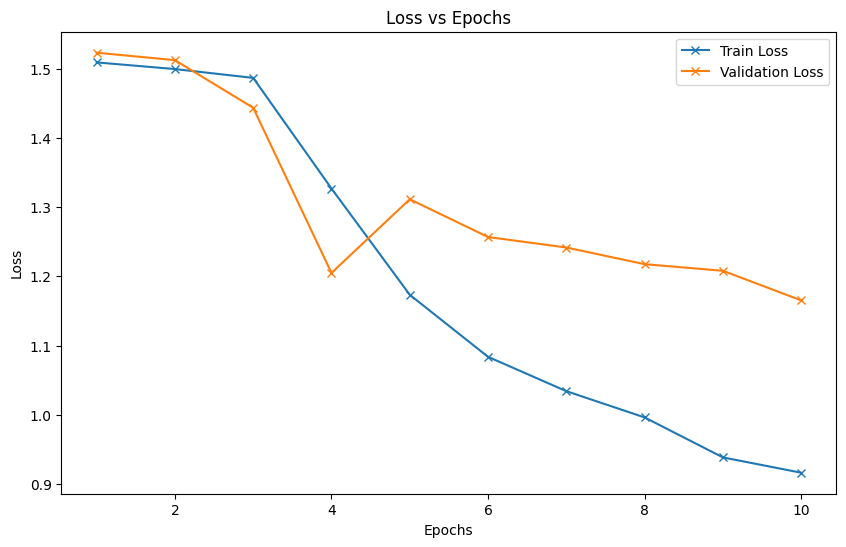

In [10]:
import matplotlib.pyplot as plt

# 提取损失数据
def extract_losses(loss_data):
    train_losses = [loss.get('train_loss', 0) for loss in loss_data]
    valid_losses = [loss.get('valid_loss', 0) for loss in loss_data]
    return train_losses, valid_losses

# 绘制训练损失和验证损失随 Epoch 变化的图
def plot_losses(epochs, train_losses, valid_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='x')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='x')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')
    plt.show()

# 示例：假设 loss_data 是已获得的损失数据

# 1. 设置 Epochs
epochs = range(1, len(train_losses) + 1)

# 2. 绘制损失图
plot_losses(epochs, train_losses, valid_losses)
